In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download oddrationale/mnist-in-csv
! unzip mnist-in-csv.zip

Dataset URL: https://www.kaggle.com/datasets/oddrationale/mnist-in-csv
License(s): CC0-1.0
 72% 11.0M/15.2M [00:00<00:00, 56.4MB/s]
100% 15.2M/15.2M [00:00<00:00, 72.8MB/s]
Archive:  mnist-in-csv.zip
  inflating: mnist_test.csv          
  inflating: mnist_train.csv         


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Config

In [ ]:
dataset_config = {
  "im_path": 'mnist'
}

diffusion_config = {
  "num_timesteps" : 1000,
  "beta_start" : 0.0001,
  "beta_end" : 0.02,
}

model_config = {
  "im_channels" : 1,
  "im_size" : 28,
  "down_channels" : [32, 64, 128, 256],
  "mid_channels" : [256, 256, 128],
  "down_sample" : [True, True, False],
  "time_emb_dim" : 128,
  "num_down_layers" : 2,
  "num_mid_layers" : 2,
  "num_up_layers" : 2,
  "num_heads" : 4,
}

train_config = {
  "ckpt_path": 'drive/MyDrive/ddpm/model_checkpoints',
  "imgs_path": 'drive/MyDrive/ddpm/learning_images',
  "batch_size": 64,
  "num_epochs": 40,
  "num_samples" : 10,
  "num_grid_rows" : 10,
  "lr": 0.0001,
  "ckpt_name": 'ddpm_ckpt.pth',
}

In [ ]:
import os

# Create image directory
if not os.path.exists(dataset_config['im_path']):
  os.mkdir(dataset_config['im_path'])

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Loading the Dataset

In [ ]:
import os
import cv2
from tqdm import tqdm
import numpy as np
import _csv as csv

def extract_images(save_dir, csv_fname):
    assert os.path.exists(save_dir), "Directory {} to save images does not exist".format(save_dir)
    assert os.path.exists(csv_fname), "Csv file {} does not exist".format(csv_fname)
    with open(csv_fname) as f:
        reader = csv.reader(f)
        for idx, row in enumerate(reader):
            if idx == 0:
                continue
            im = np.zeros((784))
            im[:] = list(map(int, row[1:]))
            im = im.reshape((28,28))
            if not os.path.exists(os.path.join(save_dir, row[0])):
                os.mkdir(os.path.join(save_dir, row[0]))
            cv2.imwrite(os.path.join(save_dir, row[0], '{}.png'.format(idx)), im)
            if idx % 10000 == 0:
                print('Finished creating {} images in {}'.format(idx+1, save_dir))

extract_images(dataset_config['im_path'], 'mnist_train.csv')

Finished creating 10001 images in mnist
Finished creating 20001 images in mnist
Finished creating 30001 images in mnist
Finished creating 40001 images in mnist
Finished creating 50001 images in mnist
Finished creating 60001 images in mnist


In [ ]:
import glob
import os

import torchvision
from PIL import Image
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset


class MnistDataset(Dataset):
    r"""
    Nothing special here. Just a simple dataset class for mnist images.
    Created a dataset class rather using torchvision to allow
    replacement with any other image dataset
    """
    def __init__(self, split, im_path, im_ext='png'):
        r"""
        Init method for initializing the dataset properties
        :param split: train/test to locate the image files
        :param im_path: root folder of images
        :param im_ext: image extension. assumes all
        images would be this type.
        """
        self.split = split
        self.im_ext = im_ext
        self.images, self.labels = self.load_images(im_path)

    def load_images(self, im_path):
        r"""
        Gets all images from the path specified
        and stacks them all up
        :param im_path:
        :return:
        """
        assert os.path.exists(im_path), "images path {} does not exist".format(im_path)
        ims = []
        labels = []
        for d_name in tqdm(os.listdir(im_path)):
            for fname in glob.glob(os.path.join(im_path, d_name, '*.{}'.format(self.im_ext))):
                ims.append(fname)
                labels.append(int(d_name))
        print('Found {} images for split {}'.format(len(ims), self.split))
        return ims, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        im = Image.open(self.images[index])
        im_tensor = torchvision.transforms.ToTensor()(im)

        # Convert input to -1 to 1 range.
        im_tensor = (2 * im_tensor) - 1
        return im_tensor

In [ ]:
mnist = MnistDataset('', im_path=dataset_config['im_path'])
mnist_loader = DataLoader(mnist, batch_size=train_config['batch_size'], shuffle=True, num_workers=4)

100%|██████████| 10/10 [00:00<00:00, 75.16it/s]

Found 60000 images for split 



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Building the Model

## Building the Noise Scheduler

In [ ]:
import torch


class LinearNoiseScheduler:
    r"""
    Class for the linear noise scheduler that is used in DDPM.
    """
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod)

    def add_noise(self, original, noise, t):
        r"""
        Forward method for diffusion
        :param original: Image on which noise is to be applied
        :param noise: Random Noise Tensor (from normal dist)
        :param t: timestep of the forward process of shape -> (B,)
        :return:
        """
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod.to(original.device)[t].reshape(batch_size)

        # Reshape till (B,) becomes (B,1,1,1) if image is (B,C,H,W)
        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        for _ in range(len(original_shape) - 1):
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        # Apply and Return Forward process equation
        return (sqrt_alpha_cum_prod.to(original.device) * original
                + sqrt_one_minus_alpha_cum_prod.to(original.device) * noise)

    def sample_prev_timestep(self, xt, noise_pred, t):
        r"""
            Use the noise prediction by model to get
            xt-1 using xt and the noise predicted
        :param xt: current timestep sample
        :param noise_pred: model noise prediction
        :param t: current timestep we are at
        :return:
        """
        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t] * noise_pred)) /
              torch.sqrt(self.alpha_cum_prod.to(xt.device)[t]))
        x0 = torch.clamp(x0, -1., 1.)

        mean = xt - ((self.betas.to(xt.device)[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t])
        mean = mean / torch.sqrt(self.alphas.to(xt.device)[t])

        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod.to(xt.device)[t - 1]) / (1.0 - self.alpha_cum_prod.to(xt.device)[t])
            variance = variance * self.betas.to(xt.device)[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)

            # OR
            # variance = self.betas[t]
            # sigma = variance ** 0.5
            # z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0

In [ ]:
scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                     beta_start=diffusion_config['beta_start'],
                                     beta_end=diffusion_config['beta_end'])

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def visualize_forward_process(dataset_loader, noise_scheduler, image_index=0, num_steps=100, step_interval=50):
    # Get a sample image from the dataset
    dataset_iter = iter(dataset_loader)
    images = next(dataset_iter)  # We only get one value: the images

    image = images[image_index].unsqueeze(0)  # Add batch dimension

    # Create a random noise tensor with the same shape as the image
    noise = torch.randn_like(image)

    # Set up the figure for visualization, calculating how many rows and columns for the grid
    timesteps_to_show = range(0, num_steps, step_interval)
    num_images = len(timesteps_to_show)
    grid_cols = 5
    grid_rows = (num_images + grid_cols - 1) // grid_cols  # Calculate the number of rows needed

    # Create a list to hold the images
    grid_images = []

    # Add the original image as the first image in the grid
    grid_images.append(image.squeeze(0))

    # Add noisy images at each selected timestep
    for t in timesteps_to_show:
        noisy_image = noise_scheduler.add_noise(image, noise, t)
        grid_images.append(noisy_image.squeeze(0))

    # Make the grid of images
    grid_image = make_grid(grid_images, nrow=grid_cols, padding=5)

    # Plot the grid of images
    plt.figure(figsize=(12, grid_rows * 2))
    plt.imshow(grid_image.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Forward Process: Noising at {num_steps} Steps')
    plt.show()

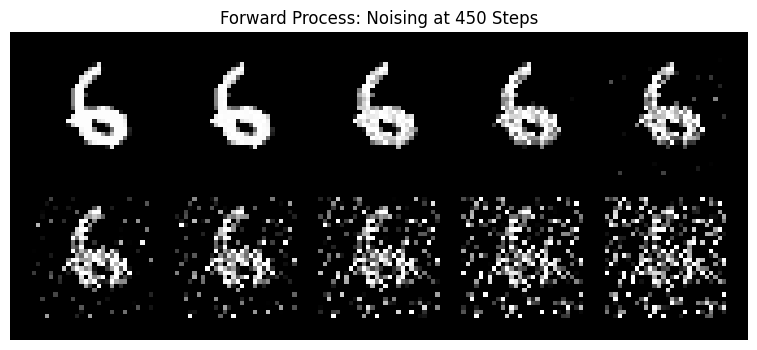

In [ ]:
image_index = 0  # Index of the image you want to visualize
num_steps = 450

visualize_forward_process(mnist_loader, scheduler, image_index=image_index, num_steps=num_steps)

## Building the U-NET Model

In [ ]:
import torch
import torch.nn as nn


def get_time_embedding(time_steps, temb_dim):
    r"""
    Convert time steps tensor into an embedding using the
    sinusoidal time embedding formula
    :param time_steps: 1D tensor of length batch size
    :param temb_dim: Dimension of the embedding
    :return: BxD embedding representation of B time steps
    """
    assert temb_dim % 2 == 0, "time embedding dimension must be divisible by 2"

    # factor = 10000^(2i/d_model)
    factor = 10000 ** ((torch.arange(
        start=0, end=temb_dim // 2, dtype=torch.float32, device=time_steps.device) / (temb_dim // 2))
    )

    # pos / factor
    # timesteps B -> B, 1 -> B, temb_dim
    t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb

In [ ]:
class DownBlock(nn.Module):
    r"""
    Down conv block with attention.
    Sequence of following block
    1. Resnet block with time embedding
    2. Attention block
    3. Downsample using 2x2 average pooling
    """
    def __init__(self, in_channels, out_channels, t_emb_dim,
                 down_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
             for _ in range(num_layers)]
        )

        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
             for _ in range(num_layers)]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels,
                                          4, 2, 1) if self.down_sample else nn.Identity()

    def forward(self, x, t_emb):
        out = x
        for i in range(self.num_layers):

            # Resnet block of Unet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)

            # Attention block of Unet
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn

        out = self.down_sample_conv(out)
        return out

In [ ]:
class MidBlock(nn.Module):
    r"""
    Mid conv block with attention.
    Sequence of following blocks
    1. Resnet block with time embedding
    2. Attention block
    3. Resnet block with time embedding
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers+1)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers + 1)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers+1)
            ]
        )

        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
                for _ in range(num_layers)]
        )

        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers+1)
            ]
        )

    def forward(self, x, t_emb):
        out = x

        # First resnet block
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)

        for i in range(self.num_layers):

            # Attention Block
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn

            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i+1](out)
            out = out + self.t_emb_layers[i+1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i+1](out)
            out = out + self.residual_input_conv[i+1](resnet_input)

        return out

In [ ]:
class UpBlock(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )

        self.attention_norms = nn.ModuleList(
            [
                nn.GroupNorm(8, out_channels)
                for _ in range(num_layers)
            ]
        )

        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)
            ]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()

    def forward(self, x, out_down, t_emb):
        x = self.up_sample_conv(x)
        x = torch.cat([x, out_down], dim=1)

        out = x
        for i in range(self.num_layers):
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)

            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn

        return out

In [ ]:
class Unet(nn.Module):
    r"""
    Unet model comprising
    Down blocks, Midblocks and Uplocks
    """
    def __init__(self, model_config):
        super().__init__()
        im_channels = model_config['im_channels']
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.t_emb_dim = model_config['time_emb_dim']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']

        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-2]
        assert len(self.down_sample) == len(self.down_channels) - 1

        # Initial projection from sinusoidal time embedding
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=(1, 1))

        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels)-1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i+1], self.t_emb_dim,
                                        down_sample=self.down_sample[i], num_layers=self.num_down_layers))

        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels)-1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i+1], self.t_emb_dim,
                                      num_layers=self.num_mid_layers))

        self.ups = nn.ModuleList([])
        for i in reversed(range(len(self.down_channels)-1)):
            self.ups.append(UpBlock(self.down_channels[i] * 2, self.down_channels[i-1] if i != 0 else 16,
                                    self.t_emb_dim, up_sample=self.down_sample[i], num_layers=self.num_up_layers))

        self.norm_out = nn.GroupNorm(8, 16)
        self.conv_out = nn.Conv2d(16, im_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        # Shapes assuming downblocks are [C1, C2, C3, C4]
        # Shapes assuming midblocks are [C4, C4, C3]
        # Shapes assuming downsamples are [True, True, False]
        # B x C x H x W
        out = self.conv_in(x)
        # B x C1 x H x W

        # t_emb -> B x t_emb_dim
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)

        down_outs = []

        for idx, down in enumerate(self.downs):
            down_outs.append(out)
            out = down(out, t_emb)
        # down_outs  [B x C1 x H x W, B x C2 x H/2 x W/2, B x C3 x H/4 x W/4]
        # out B x C4 x H/4 x W/4

        for mid in self.mids:
            out = mid(out, t_emb)
        # out B x C3 x H/4 x W/4

        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
            # out [B x C2 x H/4 x W/4, B x C1 x H/2 x W/2, B x 16 x H x W]
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        # out B x C x H x W
        return out

# Training the Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = Unet(model_config).to(device)

In [ ]:
model.train()

Unet(
  (t_proj): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): DownBlock(
      (resnet_conv_first): ModuleList(
        (0): Sequential(
          (0): GroupNorm(8, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): Sequential(
          (0): GroupNorm(8, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (t_emb_layers): ModuleList(
        (0-1): 2 x Sequential(
          (0): SiLU()
          (1): Linear(in_features=128, out_features=64, bias=True)
        )
      )
      (resnet_conv_second): ModuleList(
        (0-1): 2 x Sequential(
          (0): GroupNorm(8,

In [ ]:
# Create output directories
if not os.path.exists(train_config['ckpt_path']):
  os.mkdir(train_config['ckpt_path'])

# Load checkpoint if found
if os.path.exists(os.path.join(train_config['ckpt_path'],train_config['ckpt_name'])):
  print('Loading checkpoint as found one')
  model.load_state_dict(torch.load(os.path.join(train_config['ckpt_path'],
                                                 train_config['ckpt_name']), map_location=device))

Loading checkpoint as found one


<ipython-input-40-b149f0767d11>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(train_config['ckpt_path'],


In [ ]:
from torch.optim import Adam

# Specify training parameters
num_epochs = train_config['num_epochs']
optimizer = Adam(model.parameters(), lr=train_config['lr'])
criterion = torch.nn.MSELoss()

In [ ]:
import os
from torchvision.utils import make_grid
from PIL import Image
import torch
import numpy as np
from tqdm import tqdm

def save_sample(model, scheduler, epoch_idx):
    r"""
    Sample stepwise by going backward one timestep at a time.
    We save the final x0 predictions (after the last timestep).
    """
    model.eval()  # Set model to evaluation mode for sampling

    with torch.no_grad():  # Disable gradient calculations for sampling
        xt = torch.randn((train_config['num_samples'],
                          model_config['im_channels'],
                          model_config['im_size'],
                          model_config['im_size'])).to(device)

        for i in tqdm(reversed(range(diffusion_config['num_timesteps']))):
            # Predict noise at this timestep
            noise_pred = model(xt, torch.tensor([i], device=device))

            # Get xt-1 and predicted x0
            xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.tensor(i).to(device))

            # Save the predicted x0 only at the final step (timestep i == 0)
            if i == 0:
                ims = torch.clamp(x0_pred, -1., 1.).cpu()  # Clamp to valid range
                ims = (ims + 1) / 2  # Normalize to [0, 1]
                grid = make_grid(ims, nrow=train_config['num_grid_rows'])
                img = torchvision.transforms.ToPILImage()(grid)

                # Create samples directory if it doesn't exist
                sample_dir = train_config['imgs_path']
                os.makedirs(sample_dir, exist_ok=True)

                img.save(os.path.join(sample_dir, f'x0_epoch{epoch_idx+1}_final.png'))
                img.close()

    model.train()  # Set model back to training mode after sampling

In [ ]:
# Training loop
for epoch_idx in range(7, num_epochs):
    losses = []

    for im in tqdm(mnist_loader):
        optimizer.zero_grad()
        im = im.float().to(device)

        # Sample random noise
        noise = torch.randn_like(im).to(device)

        # Sample timestep
        t = torch.randint(0, diffusion_config['num_timesteps'], (im.shape[0],)).to(device)

        # Add noise to images according to timestep
        noisy_im = scheduler.add_noise(im, noise, t)
        noise_pred = model(noisy_im, t)

        loss = criterion(noise_pred, noise)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    # Print epoch loss
    print('Finished epoch:{} | Loss : {:.4f}'.format(
        epoch_idx + 1,
        np.mean(losses),
    ))

    # Save model checkpoint
    torch.save(model.state_dict(), os.path.join(train_config['ckpt_path'],
                                                train_config['ckpt_name']))

    # Generate and save sample images every 5 epochs
    if (epoch_idx + 1) % 5 == 0:
        save_sample(model, scheduler, epoch_idx)


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 938/938 [05:34<00:00,  2.81it/s]


Finished epoch:8 | Loss : 0.0246


100%|██████████| 938/938 [05:32<00:00,  2.82it/s]


Finished epoch:9 | Loss : 0.0249


100%|██████████| 938/938 [05:32<00:00,  2.82it/s]


Finished epoch:10 | Loss : 0.0248


1000it [00:26, 38.01it/s]
100%|██████████| 938/938 [05:32<00:00,  2.82it/s]


Finished epoch:11 | Loss : 0.0249


100%|██████████| 938/938 [05:33<00:00,  2.82it/s]


Finished epoch:12 | Loss : 0.0246


100%|██████████| 938/938 [05:32<00:00,  2.82it/s]


Finished epoch:13 | Loss : 0.0248


100%|██████████| 938/938 [05:32<00:00,  2.82it/s]


Finished epoch:14 | Loss : 0.0248


100%|██████████| 938/938 [05:32<00:00,  2.82it/s]


Finished epoch:15 | Loss : 0.0247


1000it [00:25, 39.20it/s]
100%|██████████| 938/938 [05:31<00:00,  2.83it/s]


Finished epoch:16 | Loss : 0.0249


100%|██████████| 938/938 [05:31<00:00,  2.83it/s]


Finished epoch:17 | Loss : 0.0248


100%|██████████| 938/938 [05:32<00:00,  2.82it/s]


Finished epoch:18 | Loss : 0.0248


100%|██████████| 938/938 [05:32<00:00,  2.82it/s]


Finished epoch:19 | Loss : 0.0247


100%|██████████| 938/938 [05:32<00:00,  2.82it/s]


Finished epoch:20 | Loss : 0.0248


1000it [00:25, 39.35it/s]
100%|██████████| 938/938 [05:32<00:00,  2.82it/s]


Finished epoch:21 | Loss : 0.0250


100%|██████████| 938/938 [05:32<00:00,  2.82it/s]


Finished epoch:22 | Loss : 0.0248


 30%|██▉       | 281/938 [01:40<03:54,  2.80it/s]


KeyboardInterrupt: 

# Model Usage